## Step 1: Imports and Setup

In [1]:
import sys
from pathlib import Path
import torch
import torch.nn as nn
from torch.optim import Adam, SGD
from torch.optim.lr_scheduler import StepLR

# add deep_learning_tools path
package_root = Path.cwd().parent / 'deep_learning_tools'
sys.path.append(str(package_root))

from src import prepare_datasets, ModelTrainer, accuracy, precision, recall, f1_score

# parameters
dataset_name = 'CIFAR10'
data_root = Path.cwd().parent / 'data'
download_data = True
normalize_data = True

## Step 2: Data Preparation


In [2]:
# prepare datasets
trainset, valset = prepare_datasets(dataset_name, data_root, 
                                    normalize=normalize_data, 
                                    precalculated_stats=(0.4733640253543854, 0.21108488738536835))

Files already downloaded and verified
Files already downloaded and verified


## Step 3: Define CNN Architectures

### Model 1: Simple CNN


In [3]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        # input: 3x32x32
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        # output: 32x32x32
        self.relu1 = nn.ReLU()
        # output size: 32x32x32
        self.pool1 = nn.MaxPool2d(2, 2)
        # output size: 32x16x16

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        # output: 64x16x16
        self.relu2 = nn.ReLU()
        # output size: 64x16x16
        self.pool2 = nn.MaxPool2d(2, 2)
        # output size: 64x8x8

        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        # conv1
        x = self.conv1(x)  # input: [batch, 3, 32,32], output: [batch,32,32,32]
        x = self.relu1(x)  # [batch,32,32,32]
        x = self.pool1(x)  # [batch,32,16,16]
        
        # conv2
        x = self.conv2(x)  # [batch,64,16,16]
        x = self.relu2(x)  # [batch,64,16,16]
        x = self.pool2(x)  # [batch,64,8,8]
        
        x = x.view(x.size(0), -1)  # [batch, 64*8*8]
        x = self.fc1(x)  # [batch,128]
        x = self.relu3(x)  # [batch,128]
        x = self.fc2(x)  # [batch,10]
        
        return x

In [4]:
class SuperSimpleNN(nn.Module):

    def __init__(self, input_size: int, num_classes: int):
        super().__init__()
        self.fc1 = nn.Linear(input_size, num_classes)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        
        return x

## Step 4: Initialize and Train Models

### Training Function

In [5]:
def train_model(model, model_name, num_epochs=25):
    optimizer = Adam(model.parameters(), lr=3e-4)  # weight_decay=1e-4
    # scheduler = StepLR(optimizer, step_size=10, gamma=0.1)
    
    trainer = ModelTrainer(
        model=model,
        device=torch.device("cuda" if torch.cuda.is_available() else "cpu"),
        loss_fn=nn.CrossEntropyLoss(),
        optimizer=optimizer,
        scheduler=None,
        batch_size=128,
        verbose=True,
        save_metrics=False,
        early_stopping_patience=5,
        early_stopping_delta=1e-4,
        metrics=[accuracy],
        log_dir=f"logs/{model_name}",
        logger_type="file",
        run_karpathy_checks=True,
        seed=42,
        # strict_reproducibility=True
        # wandb_project="cifar10",
        # wandb_entity="futuregoose",
        # sweep=True,
    )
    
    trained_model = trainer.train(
        training_set=trainset,
        val_set=valset,
        num_epochs=num_epochs
    )
    
    return trainer

### Train Model 1: Simple CNN

In [6]:
trainset.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [9]:
model0 = SimpleCNN()
# trainer0 = train_model(model0, "SimpleCNN", num_epochs=5)

### Train Model 2: ResNet-20 Inspired

[epoch 01] train loss: 1.6478 | val loss: 1.4581 | accuracy: 45.54%
Validation loss decreased (inf --> 1.4581). Saving model.
[epoch 02] train loss: 1.0651 | val loss: 1.5618 | accuracy: 51.85%
EarlyStopping counter: 1 out of inf
[epoch 03] train loss: 0.8062 | val loss: 0.8814 | accuracy: 70.30%
Validation loss decreased (1.4581 --> 0.8814). Saving model.
[epoch 04] train loss: 0.6651 | val loss: 0.8475 | accuracy: 71.31%
Validation loss decreased (0.8814 --> 0.8475). Saving model.
[epoch 05] train loss: 0.5663 | val loss: 0.7210 | accuracy: 75.45%
Validation loss decreased (0.8475 --> 0.7210). Saving model.
[epoch 06] train loss: 0.4973 | val loss: 0.6760 | accuracy: 78.07%
Validation loss decreased (0.7210 --> 0.6760). Saving model.
[epoch 07] train loss: 0.4432 | val loss: 0.6824 | accuracy: 77.44%
EarlyStopping counter: 1 out of inf
[epoch 08] train loss: 0.3968 | val loss: 0.6503 | accuracy: 78.62%
Validation loss decreased (0.6760 --> 0.6503). Saving model.
[epoch 09] train loss

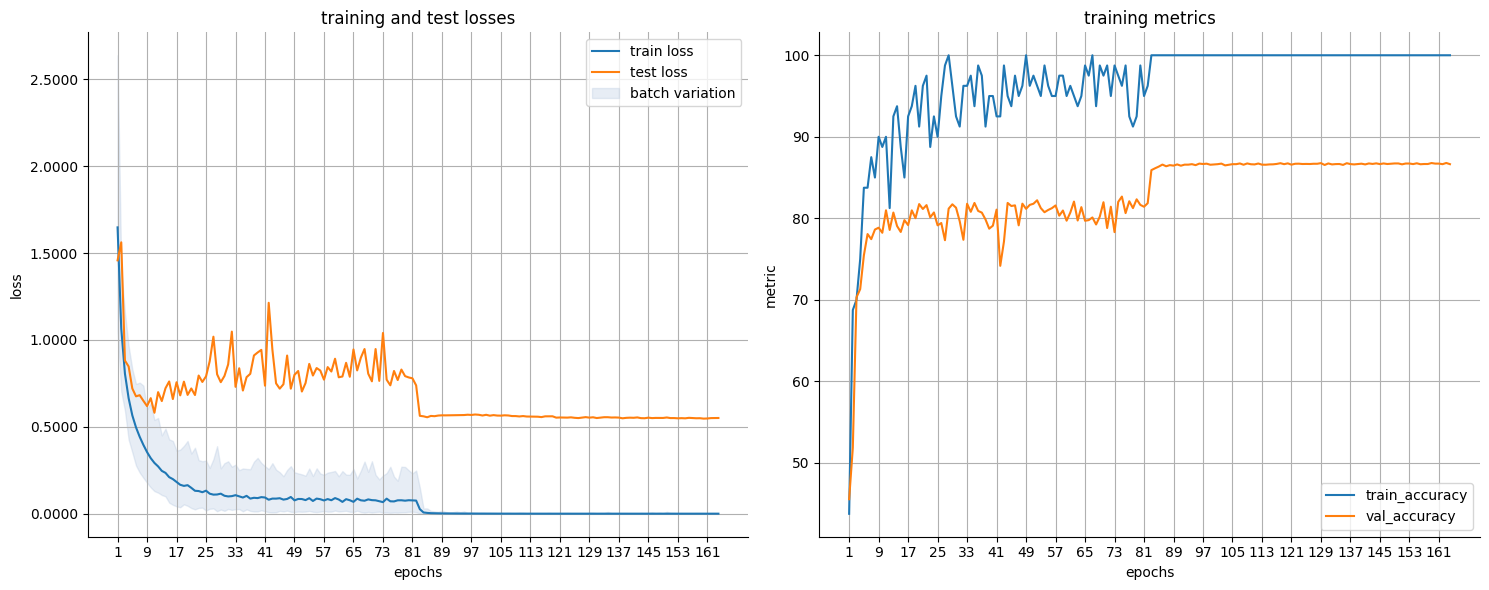

In [5]:
from torch.optim.lr_scheduler import MultiStepLR
from models.resnet20.architecture import ResNet20

def train_model(model, model_name, num_epochs=200):
    optimizer = SGD(
        model.parameters(),
        lr=0.1,
        momentum=0.9,
        weight_decay=1e-4,
        nesterov=False  # Paper doesn't mention Nesterov
    )
    
    # 32k and 48k iterations with batch_size=128
    scheduler = MultiStepLR(
        optimizer,
        milestones=[82, 123],  # ~32k and ~48k iterations
        gamma=0.1
    )
    
    trainer = ModelTrainer(
        model=model,
        device=torch.device("cuda" if torch.cuda.is_available() else "cpu"),
        loss_fn=nn.CrossEntropyLoss(),
        optimizer=optimizer,
        scheduler=scheduler,
        batch_size=128,
        verbose=True,
        save_metrics=True,
        # Remove early stopping to match paper
        early_stopping_patience=float('inf'),  # effectively no early stopping
        early_stopping_delta=1e-4,
        metrics=[accuracy],
        log_dir=f"logs/{model_name}",
        logger_type="file",
        run_karpathy_checks=False,
    )
    
    trained_model = trainer.train(
        training_set=trainset,
        val_set=valset,
        num_epochs=num_epochs  # 164 to reach ~64k iterations
    )
    
    return trainer

# Train ResNet-20
model = ResNet20()
trainer = train_model(model, "ResNet20", num_epochs=164)

### Train Model 2: Eight Layer Conv Net
- [epoch 15] train loss: 0.2931 | val loss: 0.3545 | accuracy: 89.00%
- [epoch 41] train loss: 0.2254 | val loss: 0.3331 | accuracy: 89.54%

In [1]:
import sys
from pathlib import Path
import torch
import torch.nn as nn
from torch.optim import Adam, SGD
from torch.optim.lr_scheduler import StepLR

# add deep_learning_tools path
package_root = Path.cwd().parent / 'deep_learning_tools'
sys.path.append(str(package_root))

from src import prepare_datasets, ModelTrainer, accuracy, precision, recall, f1_score

# parameters
dataset_name = 'CIFAR10'
data_root = Path.cwd().parent / 'data'
download_data = True
normalize_data = True

In [1]:
from models.eight_layer_conv_net.architecture import EightLayerConvNet
from torch.optim.lr_scheduler import MultiStepLR, StepLR
from torchvision import transforms


transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=2),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
])

transform_val = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
])

# prepare datasets with custom transforms
trainset, valset = prepare_datasets(
    dataset_name=dataset_name, 
    data_root=data_root,
    transform_train=transform_train,
    transform_test=transform_val,
    normalize=False
)

def train_model(model, model_name, num_epochs=200):
    optimizer = SGD(
        model.parameters(),
        lr=0.1,  #  0.06697728766802258
        momentum=0.9,
        weight_decay=0.01,  # 1e-4 7.677453602367855e-05
    )
    
    scheduler = MultiStepLR(
        optimizer,
        milestones=[8, 13, 36, 39],
        gamma=0.1
    )
    
    trainer = ModelTrainer(
        model=model,
        device=torch.device("cuda" if torch.cuda.is_available() else "cpu"),
        loss_fn=nn.CrossEntropyLoss(),
        optimizer=optimizer,
        scheduler=scheduler,  ################
        batch_size=1024,
        verbose=True,
        save_metrics=False,
        early_stopping_patience=3,
        early_stopping_delta=1e-4,  # 1e-4
        metrics=[accuracy],
        log_dir=f"logs/{model_name}",
        logger_type="file",
        wandb_project="cifar10",
        wandb_entity="futuregoose",
        sweep=False,
    )
    
    trained_model = trainer.train(
        training_set=trainset,
        val_set=valset,
        num_epochs=num_epochs
    )
    
    return trainer

model2 = EightLayerConvNet()
trainer2 = train_model(model2, "EightLayerConvNet", num_epochs=200)

NameError: name 'prepare_datasets' is not defined

### Train Model 3: Eight Layer Conv Net modified

In [ ]:
    max_lr = 0.1
    div_factor = 10
    initial_lr = max_lr / div_factor
    pct_start = 0.3
    final_div_factor = 1e4
    optimizer = SGD(
        model.parameters(),
        lr=initial_lr,  #  0.1
        momentum=0.9,
        weight_decay=0.01,  # 1e-4 7.677453602367855e-05
    )

20 epochs

Files already downloaded and verified
Files already downloaded and verified
Using FP16 (half precision) training
Random seed set to 42 for reproducibility.
[epoch 01] train loss: 1.6418 | val loss: 1.4179 | accuracy: 49.34%
Validation loss decreased (inf --> 1.4179). Saving model.
[epoch 02] train loss: 1.1964 | val loss: 1.1317 | accuracy: 59.39%
Validation loss decreased (1.4179 --> 1.1317). Saving model.
[epoch 03] train loss: 1.0120 | val loss: 0.9914 | accuracy: 66.61%
Validation loss decreased (1.1317 --> 0.9914). Saving model.
[epoch 04] train loss: 0.8752 | val loss: 0.9583 | accuracy: 66.80%
Validation loss decreased (0.9914 --> 0.9583). Saving model.
[epoch 05] train loss: 0.7845 | val loss: 0.8075 | accuracy: 72.44%
Validation loss decreased (0.9583 --> 0.8075). Saving model.
[epoch 06] train loss: 0.7121 | val loss: 0.7885 | accuracy: 72.86%
Validation loss decreased (0.8075 --> 0.7885). Saving model.
[epoch 07] train loss: 0.6578 | val loss: 0.6876 | accuracy: 77.30%
Valid

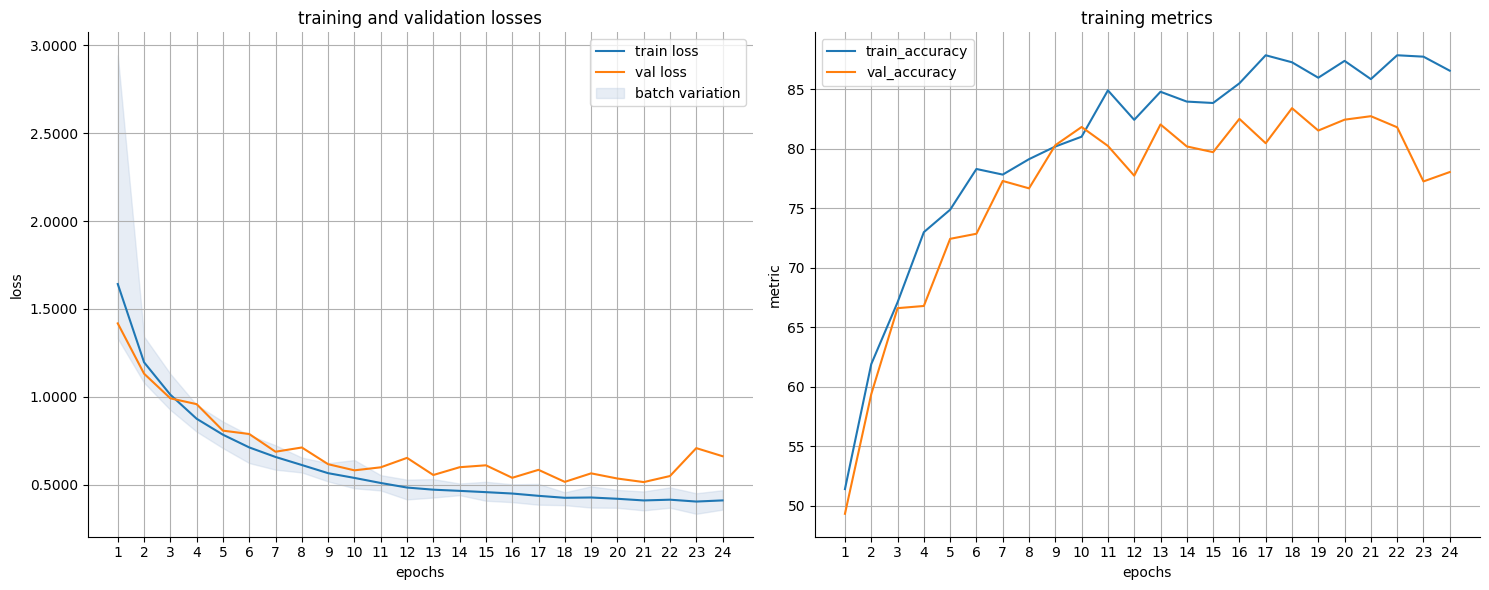

In [7]:
import sys
from pathlib import Path
import torch
import torch.nn as nn
from torch.optim import Adam, SGD
from torch.optim.lr_scheduler import StepLR

# add deep_learning_tools path
package_root = Path.cwd().parent / 'deep_learning_tools'
sys.path.append(str(package_root))

from src import prepare_datasets, ModelTrainer, accuracy, precision, recall, f1_score

# parameters
dataset_name = 'CIFAR10'
data_root = Path.cwd().parent / 'data'
download_data = True
normalize_data = True

from models.mod_eight_layer_conv_net.architecture import ModEightLayerConvNet
from torch.optim.lr_scheduler import MultiStepLR, StepLR, OneCycleLR
from torchvision import transforms
import math

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=2, padding_mode='reflect'),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
])

transform_val = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
])

# prepare datasets with custom transforms
trainset, valset = prepare_datasets(
    dataset_name=dataset_name, 
    data_root=data_root,
    transform_train=transform_train,
    transform_test=transform_val,
    normalize=False
)

def train_model(model, model_name, num_epochs=200):

    max_lr = 0.1
    div_factor = 5        # controls initial LR: higher = lower start (max_lr/div_factor = 0.1/5 = 0.02)
    final_div_factor = 3  # controls decay speed: higher = faster decay (max_lr/final_div_factor = 0.1/3 = 0.033)
    
    # adjust warmup length based on absolute epochs, not percentage
    absolute_warmup_epochs = 8
    pct_start = absolute_warmup_epochs / num_epochs  # dynamically calculated

    initial_lr = max_lr / div_factor
    optimizer = SGD(
        model.parameters(),
        lr=initial_lr,  #  0.1
        momentum=0.9,
        weight_decay=0.01,  # 1e-4 7.677453602367855e-05
    )
    
    # scheduler = MultiStepLR(
    #     optimizer,
    #     milestones=[8, 13, 40],
    #     gamma=0.1
    # )

    # calculate total steps
    steps_per_epoch = math.ceil(len(trainset) / 1024)
    total_steps = steps_per_epoch * num_epochs

    scheduler = OneCycleLR(
        optimizer,
        max_lr=max_lr,                     # (1) Peak learning rate
        total_steps=total_steps,           # (2) Total number of training iterations
        pct_start=pct_start,               # (3) Percentage of training spent in warmup
        div_factor=div_factor,             # (4) Initial LR division factor  (Initial LR = max_lr/div_factor = 0.1/5 = 0.02)
        final_div_factor=final_div_factor, # (5) Final LR division factor    (Final LR = max_lr/final_div_factor = 0.1/15 = 0.007)
        anneal_strategy='cos'              # (6) Type of annealing (default 'cos')
    )
    
    trainer = ModelTrainer(
        model=model,
        device=torch.device("cuda" if torch.cuda.is_available() else "cpu"),
        loss_fn=nn.CrossEntropyLoss(),
        optimizer=optimizer,
        scheduler=scheduler,  ################
        batch_size=1024,
        verbose=True,
        save_metrics=False,
        early_stopping_patience=3,
        early_stopping_delta=1e-4,  # 1e-4
        metrics=[accuracy],
        log_dir=f"logs/{model_name}",
        logger_type="file",
        wandb_project="cifar10",
        wandb_entity="futuregoose",
        sweep=False,
        seed=42
    )
    
    trained_model = trainer.train(
        training_set=trainset,
        val_set=valset,
        num_epochs=num_epochs
    )
    
    return trainer

model3 = ModEightLayerConvNet()
trainer3 = train_model(model3, "ModEightLayerConvNet", num_epochs=30)


```text
Epoch 0:   lr = 0.0004    (Initial LR)
Epoch 15:  lr = 0.005     (Middle of warmup)
Epoch 30:  lr = 0.01      (Peak LR, end of warmup)
Epoch 65:  lr = 0.005     (Middle of annealing)
Epoch 100: lr = 0.000001  (Final LR)


Learning Rate
   ^
   |
0.01 -          /\
   |         /    \
   |      /        \
0.005-   /          \
   |  /              \
   |/                 \
0.0004                 \
   |                    \
   +---------------------> Epochs
   0   30   65    100
```


### Train Model 4: Airbench94 port

In [1]:
import sys
from pathlib import Path
import torch
import torch.nn as nn
from torch.optim import Adam, SGD
from torch.optim.lr_scheduler import StepLR

# add deep_learning_tools path
package_root = Path.cwd().parent / 'deep_learning_tools'
sys.path.append(str(package_root))

from src import prepare_datasets, ModelTrainer, accuracy, precision, recall, f1_score

# parameters
dataset_name = 'CIFAR10'
data_root = Path.cwd().parent / 'data'
download_data = True
normalize_data = True

Files already downloaded and verified
Files already downloaded and verified
Using FP16 (half precision) training
[epoch 01] train loss: 2.0105 | val loss: 2.0531 | accuracy: 36.54%
Validation loss decreased (inf --> 2.0531). Saving model.
[epoch 02] train loss: 1.6667 | val loss: 1.7387 | accuracy: 56.11%
Validation loss decreased (2.0531 --> 1.7387). Saving model.
[epoch 03] train loss: 1.4919 | val loss: 1.6301 | accuracy: 57.81%
Validation loss decreased (1.7387 --> 1.6301). Saving model.
[epoch 04] train loss: 1.3817 | val loss: 1.4834 | accuracy: 66.10%
Validation loss decreased (1.6301 --> 1.4834). Saving model.
[epoch 05] train loss: 1.3196 | val loss: 1.4278 | accuracy: 72.66%
Validation loss decreased (1.4834 --> 1.4278). Saving model.
[epoch 06] train loss: 1.2898 | val loss: 1.3383 | accuracy: 76.44%
Validation loss decreased (1.4278 --> 1.3383). Saving model.
[epoch 07] train loss: 1.2608 | val loss: 1.4470 | accuracy: 70.74%
EarlyStopping counter: 1 out of 5
[epoch 08] tra

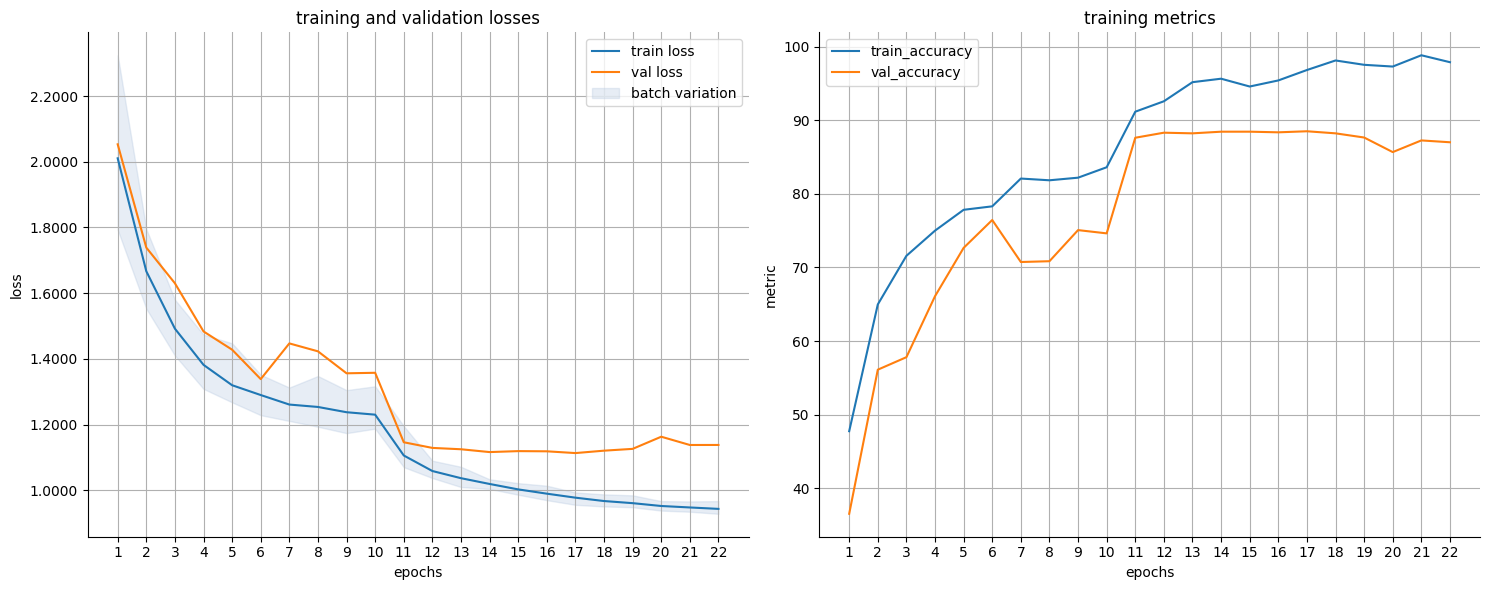

/home/gustaf/projects/deeplearning/deep_learning_tools/src/training/trainer.py:209: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(self.early_stopping.best_model_p

In [2]:
# airbench94 inspired
from torch.optim.lr_scheduler import MultiStepLR, StepLR
from torchvision import transforms
from models.airbench94_inspired.architecture import Airbench94InspiredNet
from models.eight_layer_conv_net.architecture import EightLayerConvNet
from torch.optim.lr_scheduler import LambdaLR
from src import AlternatingFlipDataset, MultiCropTTAWrapper


transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=2, padding_mode='reflect'),
    # transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
])

transform_val = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
])

# prepare datasets with custom transforms
trainset, valset = prepare_datasets(
    dataset_name=dataset_name, 
    data_root=data_root,
    transform_train=transform_train,
    transform_test=transform_val,
    normalize=False
)

trainset = AlternatingFlipDataset(trainset)

def train_model(model, model_name, num_epochs=200):

    optimizer = SGD(
        model.parameters(),
        lr=0.1,  #  0.06697728766802258
        momentum=0.85,  # 0.9
        weight_decay=0.0153,  # 0.01
        nesterov=True
    )
    
    scheduler = MultiStepLR(
        optimizer,
        milestones=[20],
        gamma=0.1
    )
    
    trainer = ModelTrainer(
        model=model,
        device=torch.device("cuda" if torch.cuda.is_available() else "cpu"),
        loss_fn=nn.CrossEntropyLoss(label_smoothing=0.2),
        optimizer=optimizer,
        scheduler=scheduler,  ################
        batch_size=1024,
        verbose=True,
        save_metrics=False,
        early_stopping_patience=5,
        early_stopping_delta=1e-4,  # 1e-4
        metrics=[accuracy],
        log_dir=f"logs/{model_name}",
        logger_type="file",
        wandb_project="cifar10",
        wandb_entity="futuregoose",
        sweep=False,
    )
    
    trained_model = trainer.train(
        training_set=trainset,
        val_set=valset,
        num_epochs=num_epochs
    )
    
    return trainer

model5 =  Airbench94InspiredNet()  # EightLayerConvNet()  # 
trainer = train_model(model5, "Airbench94InspiredNet", num_epochs=200)

```python
Training setup:
- Total training steps: 2160
- Steps per epoch: 48
- Peak step: 496 (Epoch 10.3)

Learning rate schedule:
- Initial LR: 0.2000
- Peak LR: 1.0000
- Final LR: 0.0700

Learning rate progression:
Step    0 (Epoch   0.0): LR = 0.2000
Step  248 (Epoch   5.2): LR = 0.6000
Step  496 (Epoch  10.3): LR = 1.0000
Step 1328 (Epoch  27.7): LR = 0.5350
Step 2159 (Epoch  45.0): LR = 0.0706

In [1]:
import sys
from pathlib import Path
import torch
import torch.nn as nn
from torch.optim import Adam, SGD
from torch.optim.lr_scheduler import StepLR

# add deep_learning_tools path
package_root = Path.cwd().parent / 'deep_learning_tools'
sys.path.append(str(package_root))

from src import prepare_datasets, ModelTrainer, accuracy, precision, recall, f1_score

# parameters
dataset_name = 'CIFAR10'
data_root = Path.cwd().parent / 'data'
download_data = True
normalize_data = True

In [4]:
# with triangular lr
# airbench94 inspired
from torch.optim.lr_scheduler import MultiStepLR, StepLR
from torchvision import transforms
from models.airbench94_inspired.architecture import Airbench94InspiredNet
from models.eight_layer_conv_net.architecture import EightLayerConvNet
from torch.optim.lr_scheduler import LambdaLR
from src import AlternatingFlipDataset, MultiCropTTAWrapper
from math import ceil


transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=2, padding_mode='reflect'),
    # transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
])

transform_val = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
])

# prepare datasets with custom transforms
trainset, valset = prepare_datasets(
    dataset_name=dataset_name, 
    data_root=data_root,
    transform_train=transform_train,
    transform_test=transform_val,
    normalize=False
)

trainset = AlternatingFlipDataset(trainset)

def train_model(model, model_name, num_epochs=200):
    batch_size = 1024
    
    def triangle(steps, start=0, end=0, peak=0.5):
        xp = torch.tensor([0, int(peak * steps), steps])
        fp = torch.tensor([start, 1.0, end])
        x = torch.arange(1 + steps)
        m = (fp[1:] - fp[:-1]) / (xp[1:] - xp[:-1])
        b = fp[:-1] - (m * xp[:-1])
        indices = torch.sum(torch.ge(x[:,None], xp[None,:]), 1) - 1
        indices = torch.clamp(indices, 0, len(m) - 1)
        return m[indices] * x + b[indices]
    
    total_train_steps = ceil(len(trainset) // batch_size * num_epochs)
    lr_schedule = triangle(total_train_steps, start=0.2, end=0.07, peak=0.23)

    optimizer = SGD(
        model.parameters(),
        lr=0.1,  #  0.06697728766802258
        momentum=0.9,
        weight_decay=5e-4,  # 1e-4 7.677453602367855e-05
        nesterov=True
    )
    
    # scheduler = MultiStepLR(
    #     optimizer,
    #     milestones=[9],
    #     gamma=0.1
    # )
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lambda i: float(lr_schedule[i]))


    trainer = ModelTrainer(
        model=model,
        device=torch.device("cuda" if torch.cuda.is_available() else "cpu"),
        loss_fn=nn.CrossEntropyLoss(label_smoothing=0.2),
        optimizer=optimizer,
        scheduler=scheduler,  ################
        batch_size=batch_size,
        verbose=True,
        save_metrics=False,
        early_stopping_patience=5,
        early_stopping_delta=1e-4,  # 1e-4
        metrics=[accuracy],
        log_dir=f"logs/{model_name}",
        logger_type="file",
        wandb_project="cifar10",
        wandb_entity="futuregoose",
        sweep=False,
        step_scheduler_batch=True,
    )
    
    trained_model = trainer.train(
        training_set=trainset,
        val_set=valset,
        num_epochs=num_epochs
    )
    
    return trainer

model5 =  Airbench94InspiredNet()  # EightLayerConvNet()  # 
trainer = train_model(model5, "Airbench94InspiredNet", num_epochs=200)

Files already downloaded and verified
Files already downloaded and verified
Using FP16 (half precision) training
[epoch 01] train loss: 2.1812 | val loss: 2.1027 | accuracy: 34.92%
Validation loss decreased (inf --> 2.1027). Saving model.
[epoch 02] train loss: 1.9556 | val loss: 1.8703 | accuracy: 46.06%
Validation loss decreased (2.1027 --> 1.8703). Saving model.
[epoch 03] train loss: 1.7935 | val loss: 1.7241 | accuracy: 52.86%
Validation loss decreased (1.8703 --> 1.7241). Saving model.
[epoch 04] train loss: 1.6702 | val loss: 1.6555 | accuracy: 57.26%
Validation loss decreased (1.7241 --> 1.6555). Saving model.
[epoch 05] train loss: 1.5744 | val loss: 1.5484 | accuracy: 64.93%
Validation loss decreased (1.6555 --> 1.5484). Saving model.
[epoch 06] train loss: 1.5001 | val loss: 1.4868 | accuracy: 68.06%
Validation loss decreased (1.5484 --> 1.4868). Saving model.
[epoch 07] train loss: 1.4410 | val loss: 1.4414 | accuracy: 70.79%
Validation loss decreased (1.4868 --> 1.4414). S

In [7]:
# with triangular lr
# airbench94 inspired
from torch.optim.lr_scheduler import MultiStepLR, StepLR
from torchvision import transforms
from models.airbench94_inspired.architecture import Airbench94InspiredNet
from models.eight_layer_conv_net.architecture import EightLayerConvNet
from torch.optim.lr_scheduler import LambdaLR
from src import AlternatingFlipDataset, MultiCropTTAWrapper
from math import ceil


transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=2, padding_mode='reflect'),
    # transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
])

transform_val = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
])

# prepare datasets with custom transforms
trainset, valset = prepare_datasets(
    dataset_name=dataset_name, 
    data_root=data_root,
    transform_train=transform_train,
    transform_test=transform_val,
    normalize=False
)

trainset = AlternatingFlipDataset(trainset)

def train_model(model, model_name, num_epochs=200):
    batch_size = 1024
    momentum = 0.85
    
    # Decouple learning rate
    kilostep_scale = 1024 * (1 + 1 / (1 - momentum))
    base_lr = 11.5 / kilostep_scale  # Their base learning rate is 11.5
    bias_lr = base_lr * 64.0  # bias_scaler from their hyp
    weight_decay = 0.0153 * batch_size / kilostep_scale
    
    # Separate parameters for different learning rates
    norm_biases = [p for k, p in model.named_parameters() if 'norm' in k and p.requires_grad]
    other_params = [p for k, p in model.named_parameters() if 'norm' not in k and p.requires_grad]
    param_configs = [
        dict(params=norm_biases, lr=bias_lr, weight_decay=weight_decay/bias_lr),
        dict(params=other_params, lr=base_lr, weight_decay=weight_decay/base_lr)
    ]
    
    total_train_steps = ceil(len(trainset) // batch_size * num_epochs)
    
    def get_lr(step):
        warmup_steps = int(total_train_steps * 0.23)
        warmdown_steps = total_train_steps - warmup_steps
        if step < warmup_steps:
            frac = step / warmup_steps
            return 0.2 * (1 - frac) + 1.0 * frac
        else:
            frac = (step - warmup_steps) / warmdown_steps
            return 1.0 * (1 - frac) + 0.07 * frac
    
    optimizer = torch.optim.SGD(
        param_configs,
        momentum=momentum,
        nesterov=True
    )
    
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, get_lr)
    
    trainer = ModelTrainer(
        model=model,
        device=torch.device("cuda" if torch.cuda.is_available() else "cpu"),
        loss_fn=nn.CrossEntropyLoss(label_smoothing=0.2),
        optimizer=optimizer,
        scheduler=scheduler,
        batch_size=batch_size,
        verbose=True,
        save_metrics=False,
        early_stopping_patience=20,
        early_stopping_delta=1e-4,
        metrics=[accuracy],
        log_dir=f"logs/{model_name}",
        logger_type="file",
        step_scheduler_batch=True
    )
    
    return trainer

model5 =  Airbench94InspiredNet()  # EightLayerConvNet()  # 
trainer = train_model(model5, "Airbench94InspiredNet", num_epochs=200)

Files already downloaded and verified
Files already downloaded and verified
Using FP16 (half precision) training


In [13]:
# testing triangular lr
def train_model(model, model_name, num_epochs=45):
    batch_size = 1024
    
    def triangle(steps, start=0.2, end=0.07, peak=0.23):
        xp = torch.tensor([0, int(peak * steps), steps])
        fp = torch.tensor([start, 1.0, end])
        x = torch.arange(1 + steps)
        m = (fp[1:] - fp[:-1]) / (xp[1:] - xp[:-1])
        b = fp[:-1] - (m * xp[:-1])
        indices = torch.sum(torch.ge(x[:,None], xp[None,:]), 1) - 1
        indices = torch.clamp(indices, 0, len(m) - 1)
        return m[indices] * x + b[indices]
    
    total_train_steps = ceil(len(trainset) // batch_size * num_epochs)
    lr_schedule = triangle(total_train_steps)
    peak_step = int(0.23 * total_train_steps)
    
    print(f"Training setup:")
    print(f"- Total training steps: {total_train_steps}")
    print(f"- Steps per epoch: {len(trainset) // batch_size}")
    print(f"- Peak step: {peak_step} (Epoch {peak_step/(len(trainset) // batch_size):.1f})")
    print(f"\nLearning rate schedule:")
    print(f"- Initial LR: {lr_schedule[0]:.4f}")
    print(f"- Peak LR: {lr_schedule[peak_step]:.4f}")
    print(f"- Final LR: {lr_schedule[-1]:.4f}")
    
    # Debug: Print LR values at key points
    print("\nLearning rate progression:")
    key_points = [0, peak_step//2, peak_step, peak_step + (total_train_steps-peak_step)//2, total_train_steps-1]
    for step in key_points:
        print(f"Step {step:4d} (Epoch {step/(len(trainset) // batch_size):5.1f}): LR = {lr_schedule[step]:.4f}")
    
    optimizer = torch.optim.SGD(
        model.parameters(),
        lr=1.0,  # Base LR - will be modified by scheduler
        momentum=0.9,
        weight_decay=0.01,
        nesterov=True
    )
    
    class DebugTrainer(ModelTrainer):
        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            self.global_step = 0
            
        def train_epoch(self, train_loader):
            epoch = self.global_step // len(train_loader)
            curr_lr = self.optimizer.param_groups[0]['lr']
            print(f"\nEpoch {epoch:2d} - Starting LR: {curr_lr:.4f}")
            
            epoch_metrics = super().train_epoch(train_loader)
            
            curr_lr = self.optimizer.param_groups[0]['lr']
            print(f"Epoch {epoch:2d} - Ending LR: {curr_lr:.4f}")
            
            if self.global_step == peak_step:
                print("*** REACHED PEAK LEARNING RATE ***")
            
            self.global_step += len(train_loader)
            return epoch_metrics
            
        def train_step(self, batch):
            if self.global_step % 100 == 0:  # Print every 100 steps
                curr_lr = self.optimizer.param_groups[0]['lr']
                print(f"Step {self.global_step:4d} - LR: {curr_lr:.4f}")
            return super().train_step(batch)
    
    scheduler = torch.optim.lr_scheduler.LambdaLR(
        optimizer,
        lambda step: float(lr_schedule[step])
    )
    
    trainer = DebugTrainer(
        model=model,
        device=torch.device("cuda" if torch.cuda.is_available() else "cpu"),
        loss_fn=nn.CrossEntropyLoss(label_smoothing=0.2),
        optimizer=optimizer,
        scheduler=scheduler,
        batch_size=batch_size,
        verbose=True,
        save_metrics=False,
        early_stopping_patience=4,
        early_stopping_delta=1e-4,
        metrics=[accuracy],
        log_dir=f"logs/{model_name}",
        logger_type="file",
        step_scheduler_batch=True  # Important: step every batch
    )
    
    return trainer

model5 = Airbench94InspiredNet()
trainer = train_model(model5, "Airbench94InspiredNet", num_epochs=45)

Training setup:
- Total training steps: 2160
- Steps per epoch: 48
- Peak step: 496 (Epoch 10.3)

Learning rate schedule:
- Initial LR: 0.2000
- Peak LR: 1.0000
- Final LR: 0.0700

Learning rate progression:
Step    0 (Epoch   0.0): LR = 0.2000
Step  248 (Epoch   5.2): LR = 0.6000
Step  496 (Epoch  10.3): LR = 1.0000
Step 1328 (Epoch  27.7): LR = 0.5350
Step 2159 (Epoch  45.0): LR = 0.0706
Using FP16 (half precision) training
Initializing whitening layer...


NameError: name 'train_loader' is not defined

In [1]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=2, padding_mode='reflect'),  # Changed to reflect padding
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
])

transform_val = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
])

trainset, valset = prepare_datasets(
    dataset_name=dataset_name, 
    data_root=data_root,
    transform_train=transform_train,
    transform_test=transform_val,
    normalize=False
)

def train_model(model, model_name, num_epochs=45):  # Changed to 45 epochs as per paper
    optimizer = torch.optim.SGD(
        model.parameters(),
        lr=1.0,  # Will be modified by scheduler
        momentum=0.9,
        weight_decay=0.01,
        nesterov=True  # Enable Nesterov momentum
    )
    
    # Triangular learning rate schedule
    def get_lr(step):
        total_steps = len(trainset) // 1024 * num_epochs
        warmup_steps = int(total_steps * 0.20)  # Reaches max at 20% of training
        remaining_steps = total_steps - warmup_steps
        
        if step < warmup_steps:
            # Linear warmup from 0.2 to 1.0
            return 0.2 + (1.0 - 0.2) * (step / warmup_steps)
        else:
            # Linear decay from 1.0 to 0
            return 1.0 * (1 - (step - warmup_steps) / remaining_steps)
    
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, get_lr)
    
    trainer = ModelTrainer(
        model=model,
        device=torch.device("cuda" if torch.cuda.is_available() else "cpu"),
        loss_fn=nn.CrossEntropyLoss(label_smoothing=0.2),  # Added label smoothing
        optimizer=optimizer,
        scheduler=scheduler,
        batch_size=1024,
        verbose=True,
        save_metrics=False,
        early_stopping_patience=100,
        early_stopping_delta=1e-4,
        metrics=[accuracy],
        log_dir=f"logs/{model_name}",
        logger_type="file",
        step_scheduler_batch=False,  # Step scheduler every batch for smooth LR changes
    )
    
    trained_model = trainer.train(
        training_set=trainset,
        val_set=valset,
        num_epochs=num_epochs
    )
    
    return trainer

model = Airbench94InspiredNet()
trainer = train_model(model, "Airbench94InspiredNet", num_epochs=200)

NameError: name 'transforms' is not defined

In [1]:
# Testing alternating flip

import sys
from pathlib import Path
import torch
import torch.nn as nn
from torch.optim import Adam, SGD
from torch.optim.lr_scheduler import StepLR

# add deep_learning_tools path
package_root = Path.cwd().parent / 'deep_learning_tools'
sys.path.append(str(package_root))

from src import prepare_datasets, ModelTrainer, accuracy, precision, recall, f1_score

# parameters
dataset_name = 'CIFAR10'
data_root = Path.cwd().parent / 'data'
download_data = True
normalize_data = True

from torch.optim.lr_scheduler import MultiStepLR, StepLR
from torchvision import transforms
from models.airbench94_inspired.architecture import Airbench94InspiredNet
from models.eight_layer_conv_net.architecture import EightLayerConvNet
from torch.optim.lr_scheduler import LambdaLR
from src import AlternatingFlipDataset, MultiCropTTAWrapper

# 1. First set up the transforms and datasets
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=2),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
])

transform_val = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
])

# 2. Prepare datasets
trainset, valset = prepare_datasets(
    dataset_name=dataset_name, 
    data_root=data_root,
    transform_train=transform_train,
    transform_test=transform_val,
    normalize=False
)

# 3. Wrap training set with alternating flip and verify
trainset = AlternatingFlipDataset(trainset)
verification_passed = trainset.verify_alternating_flip(num_samples=5)

# 4. Only proceed with training if verification passes
if verification_passed:
    def train_model(model, model_name, num_epochs=200):
        optimizer = SGD(
            model.parameters(),
            lr=0.1,
            momentum=0.9,
            weight_decay=0.01,
        )
        
        scheduler = MultiStepLR(
            optimizer,
            milestones=[4],
            gamma=0.1
        )
        
        trainer = ModelTrainer(
            model=model,
            device=torch.device("cuda" if torch.cuda.is_available() else "cpu"),
            loss_fn=nn.CrossEntropyLoss(),
            optimizer=optimizer,
            scheduler=scheduler,
            batch_size=1024,
            verbose=True,
            save_metrics=False,
            early_stopping_patience=4,
            early_stopping_delta=1e-4,
            metrics=[accuracy],
            log_dir=f"logs/{model_name}",
            logger_type="file",
            wandb_project="cifar10",
            wandb_entity="futuregoose",
            sweep=False,
        )
        
        trained_model = trainer.train(
            training_set=trainset,
            val_set=valset,
            num_epochs=num_epochs
        )
        
        return trainer

    model = EightLayerConvNet()
    trainer = train_model(model, "EightLayerConvNet", num_epochs=200)
else:
    print("Training aborted due to alternating flip verification failure.")

Files already downloaded and verified
Files already downloaded and verified
Sample 0:
  Epoch 0: flipped
  Epoch 1: not flipped
  Epoch 2: flipped
Sample 1:
  Epoch 0: flipped
  Epoch 1: not flipped
  Epoch 2: flipped
Sample 2:
  Epoch 0: not flipped
  Epoch 1: flipped
  Epoch 2: not flipped
Sample 3:
  Epoch 0: flipped
  Epoch 1: not flipped
  Epoch 2: flipped
Sample 4:
  Epoch 0: not flipped
  Epoch 1: flipped
  Epoch 2: not flipped
Alternating flip verification passed! ✓
All samples follow the paper's alternating pattern:
- Each sample's flip state is determined by (hash(idx) + epoch) % 2
- This ensures consecutive epochs always have opposite flip states
- Every pair of consecutive epochs contains all possible flipped versions
Using FP16 (half precision) training
[epoch 01] train loss: 1.5818 | val loss: 1.6069 | accuracy: 43.11%
Validation loss decreased (inf --> 1.6069). Saving model.
[epoch 02] train loss: 1.1257 | val loss: 1.1675 | accuracy: 57.84%
Validation loss decreased (1.

In [ ]:
# full airbench94 port

from models.airbench94_inspired.architecture import Airbench94InspiredNet
from torch.optim.lr_scheduler import LambdaLR
from torchvision import transforms
from src import AlternatingFlipDataset, MultiCropTTAWrapper

CIFAR_MEAN = (0.4914, 0.4822, 0.4465)
CIFAR_STD = (0.2470, 0.2435, 0.2616)

# 1. Prepare datasets with correct normalization
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(CIFAR_MEAN, CIFAR_STD)
])

trainset, valset = prepare_datasets(
    dataset_name=dataset_name, 
    data_root=data_root,
    transform_train=transform,
    transform_test=transform
)

# 2. Wrap training dataset with alternating flip
trainset = AlternatingFlipDataset(trainset)

# 3. Create model
model = Airbench94InspiredNet()

def train_model(model, model_name, num_epochs=10):
    # Airbench hyperparameters
    batch_size = 1024
    momentum = 0.85
    kilostep_scale = batch_size * (1 + 1 / (1 - momentum))
    base_lr = 11.5 / kilostep_scale
    weight_decay = 0.0153 * batch_size / kilostep_scale
    
    optimizer = torch.optim.SGD(model.parameters(), 
                                lr=base_lr, 
                                momentum=momentum,
                                weight_decay=weight_decay,
                                nesterov=True)
    
    # Triangle learning rate schedule
    def get_lr(step):
        total_steps = len(trainset) // batch_size * num_epochs
        frac = step / total_steps
        return 1.0 * (1 - frac) + 0.07 * frac
    
    scheduler = LambdaLR(optimizer, get_lr)
    
    trainer = ModelTrainer(
        model=model,
        device=torch.device("cuda" if torch.cuda.is_available() else "cpu"),
        loss_fn=nn.CrossEntropyLoss(label_smoothing=0.2),
        optimizer=optimizer,
        scheduler=scheduler,
        batch_size=batch_size,
        verbose=True,
        save_metrics=True,
        early_stopping_patience=5,
        early_stopping_delta=1e-4,
        metrics=[accuracy],
        log_dir=f"logs/{model_name}",
        logger_type="file",
        step_scheduler_batch=True,
    )
    
    # Initialize whitening layer before training
    train_images = torch.stack([trainset[i][0] for i in range(5000)])
    model.init_whitening(train_images)
    
    trained_model = trainer.train(
        training_set=trainset,
        val_set=valset,
        num_epochs=num_epochs
    )
    
    return trainer

# Train the model
model = Airbench94InspiredNet()
trainer = train_model(model, "Airbench94InspiredNet", num_epochs=1000)

# For evaluation with TTA
model_with_tta = MultiCropTTAWrapper(model)

In [2]:
# full airbench94 port

from models.airbench94_inspired.architecture import Airbench94InspiredNet
from torch.optim.lr_scheduler import LambdaLR
from torchvision import transforms
from src import AlternatingFlipDataset, MultiCropTTAWrapper

CIFAR_MEAN = (0.4914, 0.4822, 0.4465)
CIFAR_STD = (0.2470, 0.2435, 0.2616)

# 1. Prepare datasets with correct normalization
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(CIFAR_MEAN, CIFAR_STD)
])

trainset, valset = prepare_datasets(
    dataset_name=dataset_name, 
    data_root=data_root,
    transform_train=transform,
    transform_test=transform
)

# 2. Wrap training dataset with alternating flip
trainset = AlternatingFlipDataset(trainset)

# 3. Create model
model = Airbench94InspiredNet()

def train_model(model, model_name, num_epochs=10):
    # Airbench hyperparameters
    batch_size = 1024
    momentum = 0.85
    kilostep_scale = batch_size * (1 + 1 / (1 - momentum))
    base_lr = 11.5 / kilostep_scale
    weight_decay = 0.0153 * batch_size / kilostep_scale
    
    # Configure optimizer with bias scaling
    norm_biases = [p for k, p in model.named_parameters() if 'norm' in k and p.requires_grad]
    other_params = [p for k, p in model.named_parameters() if 'norm' not in k and p.requires_grad]
    param_configs = [
        dict(params=norm_biases, lr=base_lr * 64.0, weight_decay=weight_decay/64.0),
        dict(params=other_params, lr=base_lr, weight_decay=weight_decay)
    ]
    optimizer = torch.optim.SGD(param_configs, momentum=momentum, nesterov=True)
    
    # Triangle learning rate schedule
    def get_lr(step):
        total_steps = len(trainset) // batch_size * num_epochs
        frac = step / total_steps
        return 1.0 * (1 - frac) + 0.07 * frac
    
    scheduler = LambdaLR(optimizer, get_lr)
    
    trainer = ModelTrainer(
        model=model,
        device=torch.device("cuda" if torch.cuda.is_available() else "cpu"),
        loss_fn=nn.CrossEntropyLoss(label_smoothing=0.2),
        optimizer=optimizer,
        scheduler=scheduler,
        batch_size=batch_size,
        verbose=True,
        save_metrics=True,
        early_stopping_patience=5,
        early_stopping_delta=1e-4,
        metrics=[accuracy],
        log_dir=f"logs/{model_name}",
        logger_type="file",
        step_scheduler_batch=True,
    )
    
    # Initialize whitening layer before training
    train_images = torch.stack([trainset[i][0] for i in range(5000)])
    model.init_whitening(train_images)
    
    trained_model = trainer.train(
        training_set=trainset,
        val_set=valset,
        num_epochs=num_epochs
    )
    
    return trainer

# Train the model
model = Airbench94InspiredNet()
trainer = train_model(model, "Airbench94InspiredNet", num_epochs=1000)

# For evaluation with TTA
model_with_tta = MultiCropTTAWrapper(model)

Files already downloaded and verified
Files already downloaded and verified
Using FP16 (half precision) training
[epoch 01] train loss: 2.3008 | val loss: 2.2879 | accuracy: 14.51%
Validation loss decreased (inf --> 2.2879). Saving model.
[epoch 02] train loss: 2.2794 | val loss: 2.2715 | accuracy: 17.50%
Validation loss decreased (2.2879 --> 2.2715). Saving model.
[epoch 03] train loss: 2.2653 | val loss: 2.2586 | accuracy: 19.35%
Validation loss decreased (2.2715 --> 2.2586). Saving model.
[epoch 04] train loss: 2.2534 | val loss: 2.2473 | accuracy: 20.67%
Validation loss decreased (2.2586 --> 2.2473). Saving model.
[epoch 05] train loss: 2.2431 | val loss: 2.2371 | accuracy: 22.41%
Validation loss decreased (2.2473 --> 2.2371). Saving model.
[epoch 06] train loss: 2.2321 | val loss: 2.2258 | accuracy: 23.35%
Validation loss decreased (2.2371 --> 2.2258). Saving model.
[epoch 07] train loss: 2.2212 | val loss: 2.2150 | accuracy: 24.22%
Validation loss decreased (2.2258 --> 2.2150). S

## Step 5: Evaluate Models

In [ ]:
def evaluate_model(trainer, model_name):
    print(f"Evaluating {model_name}...")
    trainer.load_best_model()
    # assuming val_loader is the test set
    val_loss, metrics = trainer.evaluate(trainer.metrics_history['epochs'][-1], phase='val')
    print(f"{model_name} - Loss: {val_loss:.4f}, Metrics: {metrics}")

### Evaluate All Models

In [ ]:
evaluate_model(trainer1, "SimpleCNN")
evaluate_model(trainer2, "CNNWithBatchNorm")
evaluate_model(trainer3, "CNNWithDropout")

## Step 6: Plot Loss Curves

In [ ]:
import matplotlib.pyplot as plt

def plot_loss(trainers, model_names):
    plt.figure(figsize=(10, 6))
    for trainer, name in zip(trainers, model_names):
        epochs = trainer.metrics_history['epochs']
        plt.plot(epochs, trainer.metrics_history['train_loss'], label=f"{name} Train Loss")
        plt.plot(epochs, trainer.metrics_history['val_loss'], label=f"{name} Val Loss")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Losses')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_loss([trainer1, trainer2, trainer3], ["SimpleCNN", "CNNWithBatchNorm", "CNNWithDropout"])

## Step 7: Analyze Per-Class Performance

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np

def per_class_analysis(trainer, model_name):
    trainer.load_best_model()
    trainer.model.eval()
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for data, targets in trainer.val_loader:
            data, targets = data.to(trainer.device), targets.to(trainer.device)
            outputs = trainer.model(data)
            _, preds = torch.max(outputs, 1)
            all_preds.append(preds.cpu())
            all_targets.append(targets.cpu())
    
    all_preds = torch.cat(all_preds)
    all_targets = torch.cat(all_targets)
    
    cm = confusion_matrix(all_targets, all_preds)
    classes = trainset.classes
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()
    
    print(f"Classification Report for {model_name}:\n")
    print(classification_report(all_targets, all_preds, target_names=classes))



### Analyze All Models

## Conclusion